<a href="https://colab.research.google.com/github/fourat-bs/facial_emotions_recognition/blob/main/facial_emotions_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preview
This notebook is part of academic mini-project releated to the MULTIMEDIA TECHNIQUES & AI courses to apply aquired knowledge in images processing ,features extraction and images classification with python.

##About the dataset
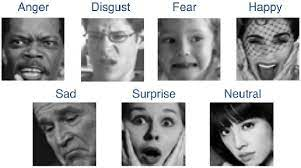

[FER2013](https://arxiv.org/abs/2105.03588) (Facial Emotion Recognition) is a collection of 30,000 facial RGB images of different expressions with size restricted to 48×48, and the main labels of it can be divided into 7 types: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral.

## Main Libraries


*   [OpenCV](https://opencv.org/)
*   [MediaPipe Solutions](https://google.github.io/mediapipe/)
*   [Keras](https://keras.io/)
*   [Matplotlib](https://matplotlib.org/)


## Summary ✈


1.   Setup
2.   Load Images from the Disk
3.   Images Exploring
4.   Extracting features using MediaPipe->FaceMesh
5.   CNN implementation with Keras to extract features with convolutions and learn those features using Dense layers



---

**Author © : [Fourat Ben Salah](mailto:mohamedfouratb@gmail.com)**



# Setup

In [ ]:
pip install mediapipe -q

     |████████████████████████████████| 32.7 MB 202 kB/s 


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import cv2
import os

# Load the Images from Disk

In [ ]:
!unzip -q /content/drive/MyDrive/fer_dataset.zip

ImageDataGenerator will help us load the images from test folder in batches of size 32 and rescaling every pixel value between 0 and 1.
This technique is used to prevent using all RAM available.

In [ ]:
images_generator = ImageDataGenerator(rescale=1.0/255.0, preprocessing_function=None)
data_loader = images_generator.flow_from_directory('/content/test', target_size=(224, 224), color_mode='rgb', batch_size=32)

Found 7178 images belonging to 7 classes.


#Images Exploring

## Loading and plotting 9 Images

loading and plotting 9 images from the next batch of images fom disk in our case it will be the first batch

In [ ]:
x, y = data_loader.next()

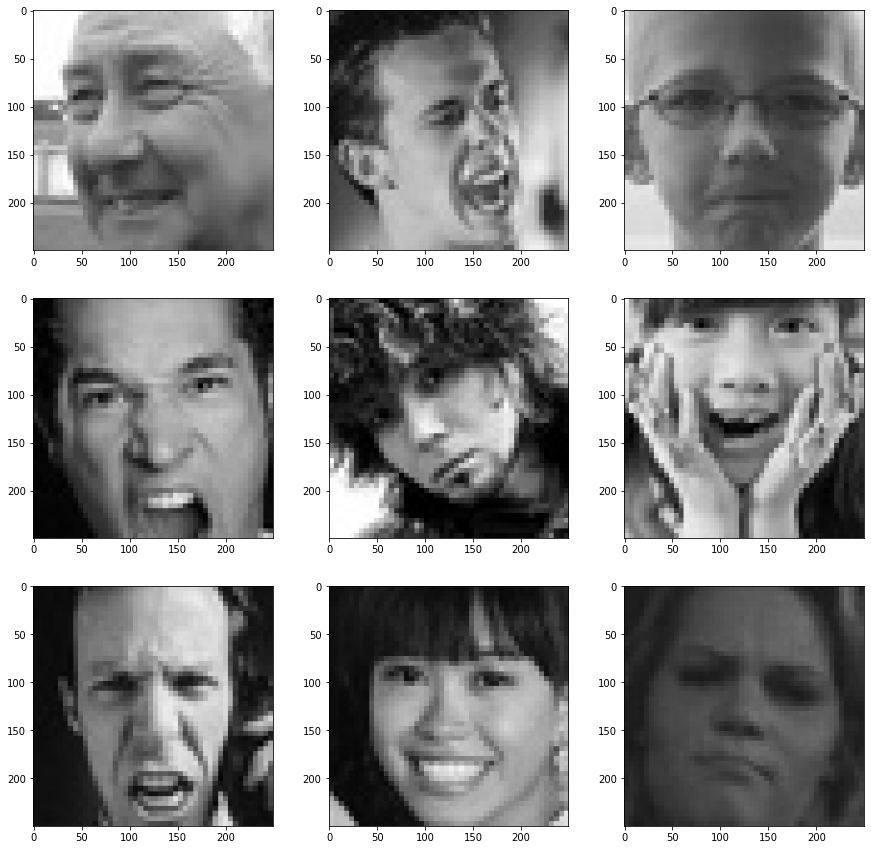

In [ ]:
def plot_images(images, preprocessing_func=None):
  fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
  if preprocessing_func is not None :
      images = [preprocessing_func(images[i]) for i in range(9)]
  for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
    else:
        ax.remove()
  plt.show()

plot_images(x)

The Images are grayscale but in RGB mode which means the value of a pixel is duplicate for each color channel. Converting the images to grayscale (48, 48, 3) -> (48, 48) will speed up processing and learning.
Hopefully ImageDataGenrator.flow_from_directory supports the RGB to grayscale conversion 

## Grayscale pixels frequency Histogram

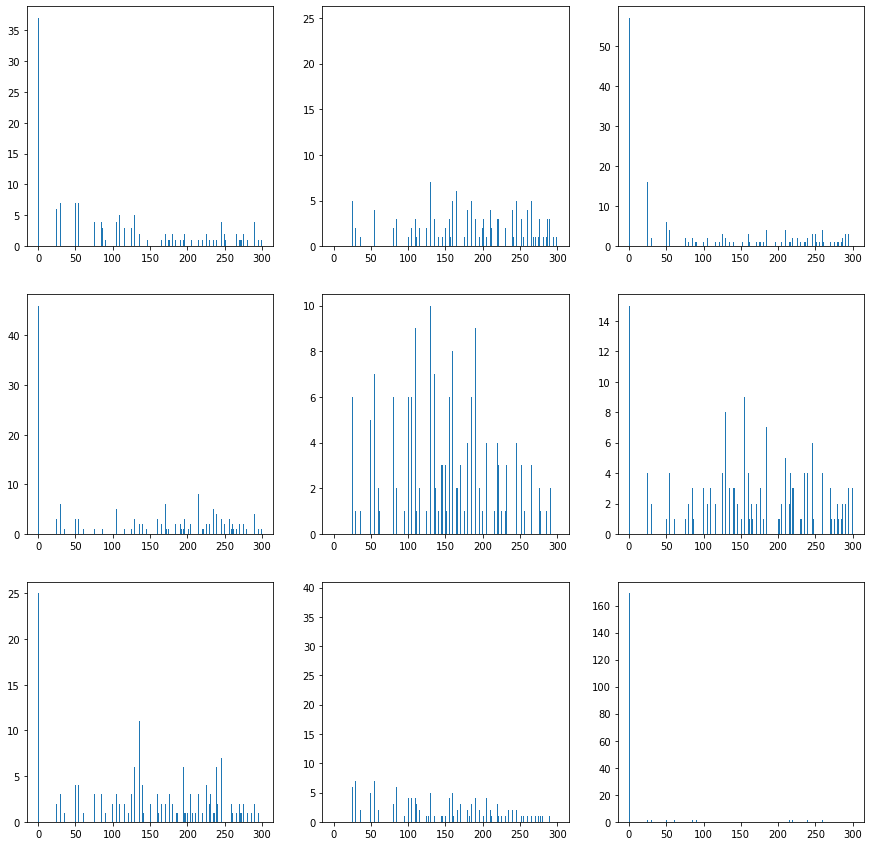

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
images = [x[i] for i in range(9)]
for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        histr = cv2.calcHist([images[i]*255],[0],None,[256],[0,256])
        ax.hist(histr, bins=256, range=[0,300])
    else:
        ax.remove()
plt.show()

outliers appeared when experimenting with different batches. Outliers may be considered as noise.

## binarization

In [ ]:
def binarization(img):
  _, thresh = cv2.threshold(img,0.55,1,cv2.THRESH_BINARY)
  return thresh

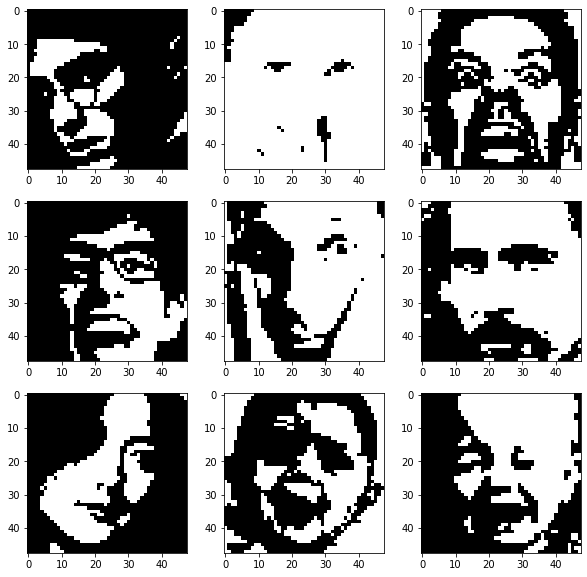

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
images = [np.squeeze(binarization(x[i])) for i in range(9)]
for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
    else:
        ax.remove()
plt.show()

# Extract features using MediaPipe -> FaceMesh
## features are extracted using the following algorithms:


1.   Face Detection using [BlazeFace](https://arxiv.org/pdf/1907.05047.pdf) algorithm
2.   Face landmarks using [Attention Mesh](https://arxiv.org/pdf/2006.10962.pdf) 



In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=0.5, circle_radius=0.5) 

In [ ]:
def face_features_detect(old_imgs, new_imgs_dir):
  with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
    for idx, file in enumerate(old_imgs):
      label = os.path.basename(os.path.dirname(file))
      image = cv2.imread(file)
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if not results.multi_face_landmarks:
        continue
      annotated_image = image.copy()

      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())
        
        mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_contours_style())
        
        mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_iris_connections_style())
      new_path = new_imgs_dir + label +'/' + str(idx) + '.jpg'
      #print(new_path)
      #print(annotated_image)
      cv2.imwrite(new_path, annotated_image)

In [ ]:
test_subdirs = [dir[0] for dir in os.walk('/content/test')][1:]
all_test_imgs = []
for dir in test_subdirs:
  imgs = os.listdir(dir)
  imgs = [dir+'/'+img for img in imgs]
  all_test_imgs.append(imgs)

def flattenL(t):
    return [item for sublist in t for item in sublist]

all_test_imgs = flattenL(all_test_imgs)
len(all_test_imgs)
all_test_imgs[1]

'/content/test/happy/PrivateTest_95916631.jpg'

In [ ]:
from PIL import Image
def resize_imgs(paths, w , h):
  for path in paths:
    img = Image.open(path)
    img = img.resize((w, h), Image.ANTIALIAS)
    img.save(path)

In [ ]:
resize_imgs(all_test_imgs, 256, 256)

In [ ]:
os.path.basename(os.path.dirname(all_test_imgs[0]))

'happy'

In [ ]:
test_subdirs

['/content/test/happy',
 '/content/test/fear',
 '/content/test/angry',
 '/content/test/neutral',
 '/content/test/disgust',
 '/content/test/surprise',
 '/content/test/sad']

In [ ]:
os.mkdir('/content/new_test')

In [ ]:
for dir in test_subdirs:
  os.mkdir(os.path.join('/content/new_test',os.path.basename(os.path.normpath(dir))))

In [ ]:
face_features_detect(all_test_imgs,'/content/new_test/')

In [ ]:
images_with_features= valid_generator.flow_from_directory('/content/new_test', target_size=(256, 256), color_mode='rgb')
x, y = images_with_features.next()

Found 6612 images belonging to 7 classes.


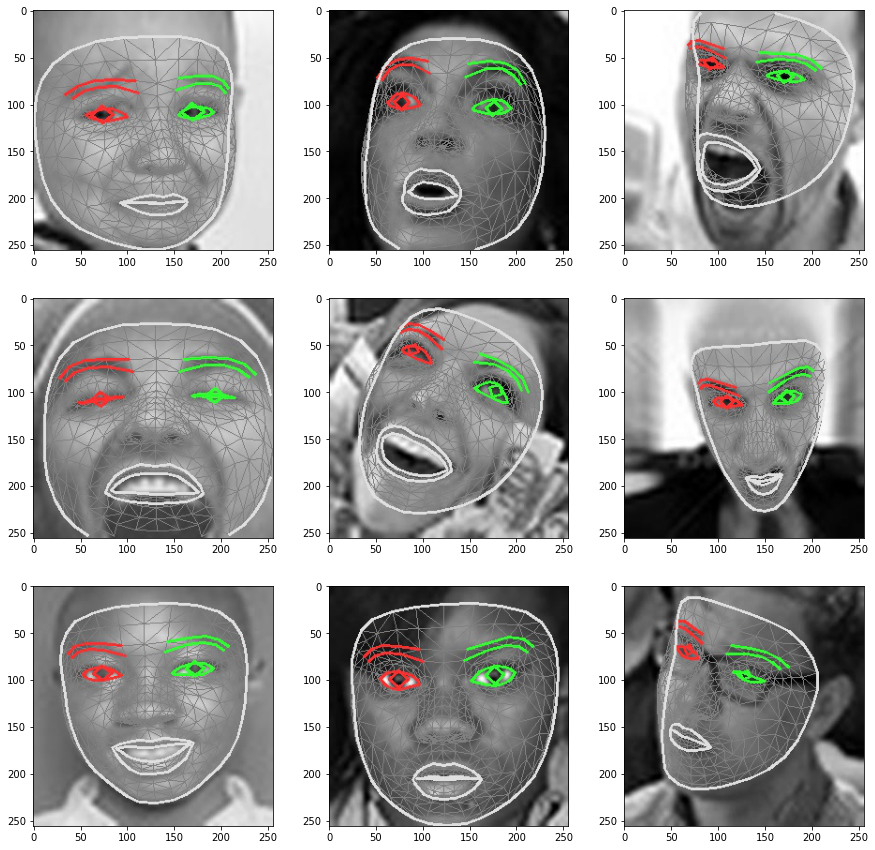

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
images = [x[i] for i in range(9)]
for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
    else:
        ax.remove()
plt.show()

# CNN  implementation to extract features with convolutions and learn those features using Dense layers

## **First we will split our data using ImageDataGenrator into :**
* train with augmentation : random shift, random flip, random rotation, random zoom ...
* validation without augmentation

In [ ]:
train_generator = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, zoom_range=0.1,
    channel_shift_range=0.0,
    horizontal_flip=True, vertical_flip=False, rescale=1./255.,
    preprocessing_function=None
)
validation_generator  = ImageDataGenerator(rescale=1./255., preprocessing_function=None)

train_loader = train_generator.flow_from_directory('/content/train', target_size=(128, 128), color_mode='grayscale', batch_size=32)
validation_loader = validation_generator.flow_from_directory('/content/test', target_size=(128, 128), color_mode='grayscale', batch_size=32)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.metrics import  CategoricalAccuracy
from tensorflow.keras.optimizers import Adam, RMSprop

## **the model  Architecture is composed of:**
* Convolutions: to extract features applying 3x3 or 5x5 filters
* Dropout: reduce overfitting
* BatchNormalization: normalize the input of the next layer and speed up learning
* MaxPooling: reduce the image size to half without loosing information
*Dense: fully connected layer of neurons to learn the features

In [ ]:
model = Sequential([layers.Conv2D(16, (5,5), activation=relu,input_shape=(128,128,1)),
                    layers.BatchNormalization(),
                    layers.Conv2D(16,(5,5), activation=relu),
                    layers.BatchNormalization(),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    layers.Dropout(0.3),
                    layers.Conv2D(32,(3,3), activation=relu),
                    layers.BatchNormalization(),
                    layers.Conv2D(32,(3,3), activation=relu),
                    layers.BatchNormalization(),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.3),
                    layers.Conv2D(64,(3,3), activation=relu),
                    layers.BatchNormalization(),
                    layers.Conv2D(64,(3,3), activation=relu),
                    layers.BatchNormalization(),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.4),
                    layers.Flatten(),
                    layers.Dense(300, activation=relu),
                    layers.Dense(7, activation=softmax)
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 124, 124, 16)      416       
                                                                 
 batch_normalization_24 (Bat  (None, 124, 124, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 120, 120, 16)      6416      
                                                                 
 batch_normalization_25 (Bat  (None, 120, 120, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 60, 16)       0         
 g2D)                                                            
                                                      

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
tensorboard = TensorBoard(
  log_dir='/content/logs',
  histogram_freq=1,
  write_images=True
)

In [ ]:
model.fit(train_loader, validation_data=validation_loader, epochs=100,
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True), tensorboard], verbose=1)

## **Metrics visualization using TensorBoard(accuracy and loss) and other options like the model graph**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs/

## **After training the model we can look at the image state when going through filters of the first convolution layer**

In [ ]:
images, labels = validation_loader.next()

In [ ]:
from tensorflow.keras.models import Model
layer_name = 'conv2d_24'
layer = model.get_layer(name=layer_name)
features_extractor = Model(inputs=model.inputs, outputs=layer.output)
feature_maps = features_extractor.predict(images)

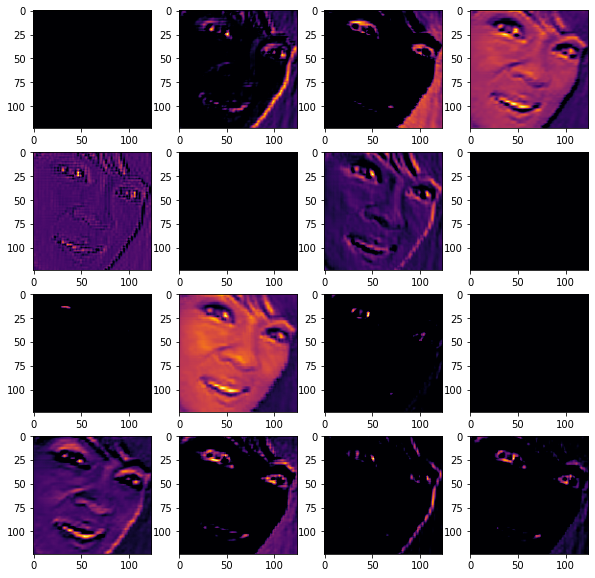

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    if i < 16:
        ax.imshow(feature_maps[0, :, :, i], cmap='inferno')
    else:
        ax.remove()
plt.show()